In [2]:
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale,robust_scale,minmax_scale,maxabs_scale
import datetime
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew

# 데이터 전처리

- 데이터 파악 

In [5]:
def read_data(dire):
    with open (dire,'r',encoding="cp949") as f:
        data=pd.read_csv(f,header=0)
        
    return data

In [6]:
train_data_dir="./training.csv"
train_data=read_data(train_data_dir)
train_data.tail()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
72978,73010,1,12/2/2009,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,...,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993
72979,73011,0,12/2/2009,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,...,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038
72980,73012,0,12/2/2009,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,...,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893
72981,73013,0,12/2/2009,ADESA,2006,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,...,10099.0,11228.0,NaN,NaN,18881,30212,GA,7000.0,0,1974
72982,73014,0,12/2/2009,ADESA,2006,3,MAZDA,MAZDA6,s,4D SEDAN S,...,11954.0,13246.0,NaN,NaN,18111,30212,GA,8000.0,0,1313


- 데이터 삭제

* 이유
    * VehYear == PunchDATE - VehYear == VehAge
    * WheelTypeID == WheelType
    * VNZIP1 == VNST
    * RefId 는 그냥 차량 인덱스
    * PRIMEUNT, AUCGUART는  NULL값이 98% 임


In [7]:
train_data=train_data.drop(["VehYear"],axis=1)
train_data=train_data.drop(["RefId"],axis=1)
train_data=train_data.drop(["Model"],axis=1)
train_data=train_data.drop(["Trim"],axis=1)
train_data=train_data.drop(["SubModel"],axis=1)
train_data=train_data.drop(["WheelType"],axis=1)
train_data=train_data.drop(["PRIMEUNIT"],axis=1)
train_data=train_data.drop(["AUCGUART"],axis=1)
train_data=train_data.drop(["VNZIP1"],axis=1)
train_data=train_data.drop(["PurchDate"],axis=1)
train_data=train_data.drop(["BYRNO"],axis=1)


In [8]:
numerical_features=train_data.select_dtypes(include=["float64", "int64"]).columns.values
categorical_features=train_data.select_dtypes(include=["object"]).columns.values

-  데이터 생성

--  연속변수는 그에 대한 평균값, 카테고리 변수는 그에 대한 최빈값으로 대체

In [9]:
train_data.isnull().sum()

IsBadBuy                                0
Auction                                 0
VehicleAge                              0
Make                                    0
Color                                   8
Transmission                            9
WheelTypeID                          3169
VehOdo                                  0
Nationality                             5
Size                                    5
TopThreeAmericanName                    5
MMRAcquisitionAuctionAveragePrice      18
MMRAcquisitionAuctionCleanPrice        18
MMRAcquisitionRetailAveragePrice       18
MMRAcquisitonRetailCleanPrice          18
MMRCurrentAuctionAveragePrice         315
MMRCurrentAuctionCleanPrice           315
MMRCurrentRetailAveragePrice          315
MMRCurrentRetailCleanPrice            315
VNST                                    0
VehBCost                                0
IsOnlineSale                            0
WarrantyCost                            0
dtype: int64

In [10]:
numerical_features=np.delete(numerical_features,2)

In [11]:
numerical_features

array(['IsBadBuy', 'VehicleAge', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost', 'IsOnlineSale',
       'WarrantyCost'], dtype=object)

In [12]:
categorical_features

array(['Auction', 'Make', 'Color', 'Transmission', 'Nationality', 'Size',
       'TopThreeAmericanName', 'VNST'], dtype=object)

In [13]:
categorical_features=np.append(categorical_features,["WheelTypeID"])

In [14]:
categorical_features

array(['Auction', 'Make', 'Color', 'Transmission', 'Nationality', 'Size',
       'TopThreeAmericanName', 'VNST', 'WheelTypeID'], dtype=object)

In [15]:
def fill_missing_values(df):
    for col in categorical_features:
        mode=df[col].mode()[0]
        df[col]=df[col].fillna(mode)
    
    for col in numerical_features:
        df[col]=df[col].fillna(df[col].median())   
    
    return df

In [16]:
def data_merge_price_avg(df):
    auction_avg=['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
    df["avg_price"]=sum(df[ave] for ave in auction_avg)/len(auction_avg)
    df=df.drop(auction_avg,axis=1)
    
    return df

In [17]:
train_data=fill_missing_values(train_data)

In [18]:
train_data=data_merge_price_avg(train_data)

In [19]:
train_data.head()

,IsBadBuy,Auction,VehicleAge,Make,Color,Transmission,WheelTypeID,VehOdo,Nationality,Size,TopThreeAmericanName,VNST,VehBCost,IsOnlineSale,WarrantyCost,avg_price
0,0,ADESA,3,MAZDA,RED,AUTO,1.0,89046,OTHER ASIAN,MEDIUM,OTHER,FL,7100.0,0,1113,10403.625
1,0,ADESA,5,DODGE,WHITE,AUTO,1.0,93593,AMERICAN,LARGE TRUCK,CHRYSLER,FL,7600.0,0,1053,9943.625
2,0,ADESA,4,DODGE,MAROON,AUTO,2.0,73807,AMERICAN,MEDIUM,CHRYSLER,FL,4900.0,0,1389,6100.250
3,0,ADESA,5,DODGE,SILVER,AUTO,1.0,65617,AMERICAN,COMPACT,CHRYSLER,FL,4100.0,0,630,3662.375
4,0,ADESA,4,FORD,SILVER,MANUAL,2.0,69367,AMERICAN,COMPACT,FORD,FL,4000.0,0,1020,5959.750


In [20]:
train_data.loc[train_data['Transmission']=="Manual","Transmission"]="MANUAL"

In [21]:
# train_data.loc[train["WheelType"].isnull(),"WheelType"]="Alloy"
# train_data.loc[[15906, 24567, 24578, 70432, 70434, 70437, 70445, 70446, 70450],["Transmission"]]="AUTO"
# train_data.loc[train['Transmission']=="Manual","Transmission"]="MANUAL"


# train_data.dropna(subset=["Color"], inplace=True)
# train_data.dropna(subset=["MMRAcquisitionAuctionAveragePrice"], inplace=True)
# train_data.dropna(subset=["MMRCurrentAuctionAveragePrice"], inplace=True)
# train_data.dropna(subset=["Size"], inplace=True)

- 데이터 분포 살피기

In [22]:
train_data.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Color', 'Transmission',
       'WheelTypeID', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'avg_price'],
      dtype='object')

In [23]:
transf_contin_value=["VehicleAge","VehOdo","VehBCost","WarrantyCost","avg_price"]

#### 연속변수 분포확인

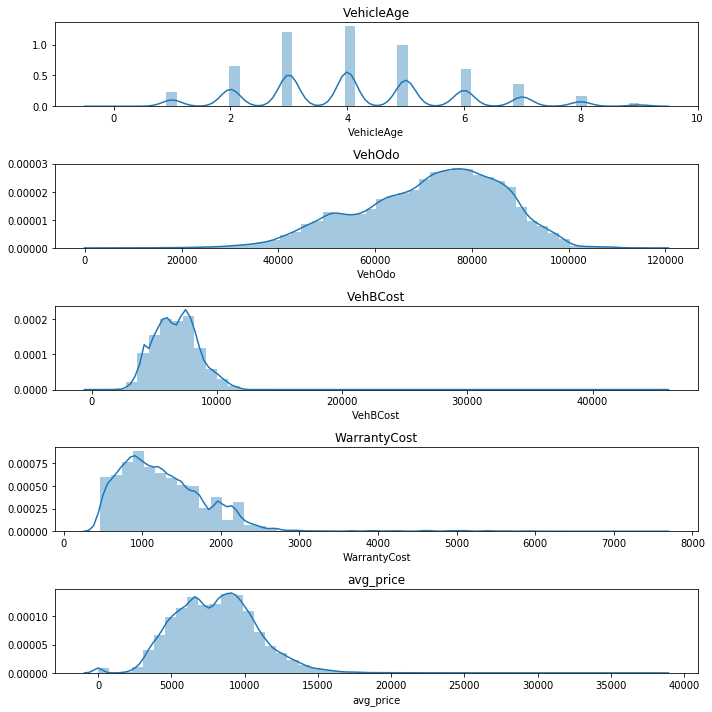

In [24]:
plt.figure(figsize=(10,10))
for i in range(len(transf_contin_value)):
    plt.subplot(5,1,i+1)
#     try:
    sns.distplot(train_data[transf_contin_value[i]])
        
#     except:
    plt.title(transf_contin_value[i])
#         continue
plt.tight_layout()
plt.show()

* vehOdo, vehicleAge는 정규분포 형태를 띠고 있다.
* VehBCost, WarrantyCost, avg_price는 왼쪽으로 skew된 값을 보여주고 있다. 

#### 카테고리변수 분포확인

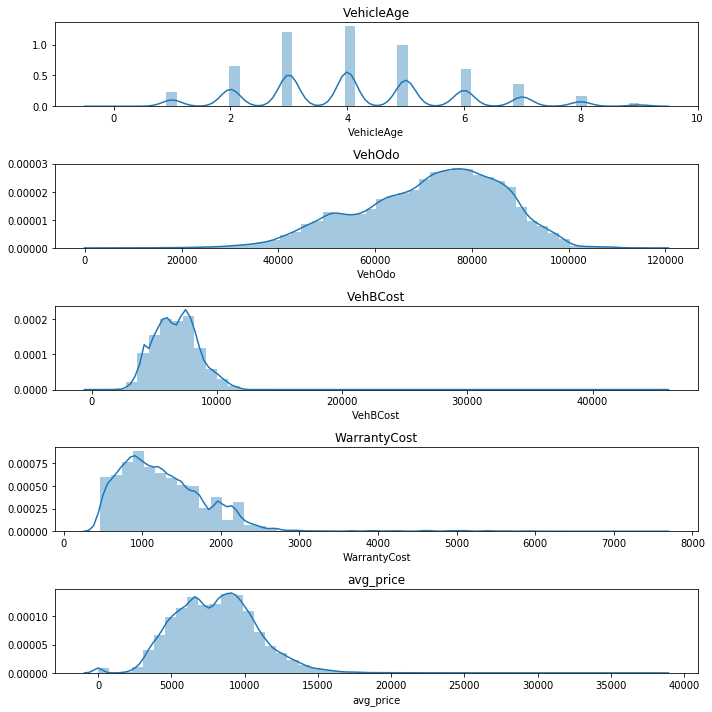

In [47]:
plt.figure(figsize=(10,10))
for i in range(len(transf_contin_value)):
    plt.subplot(5,1,i+1)
#     try:
    sns.distplot(train_data[transf_contin_value[i]])
        
#     except:
    plt.title(transf_contin_value[i])
#         continue
plt.tight_layout()
plt.show()

In [48]:
len(categorical_features)

9

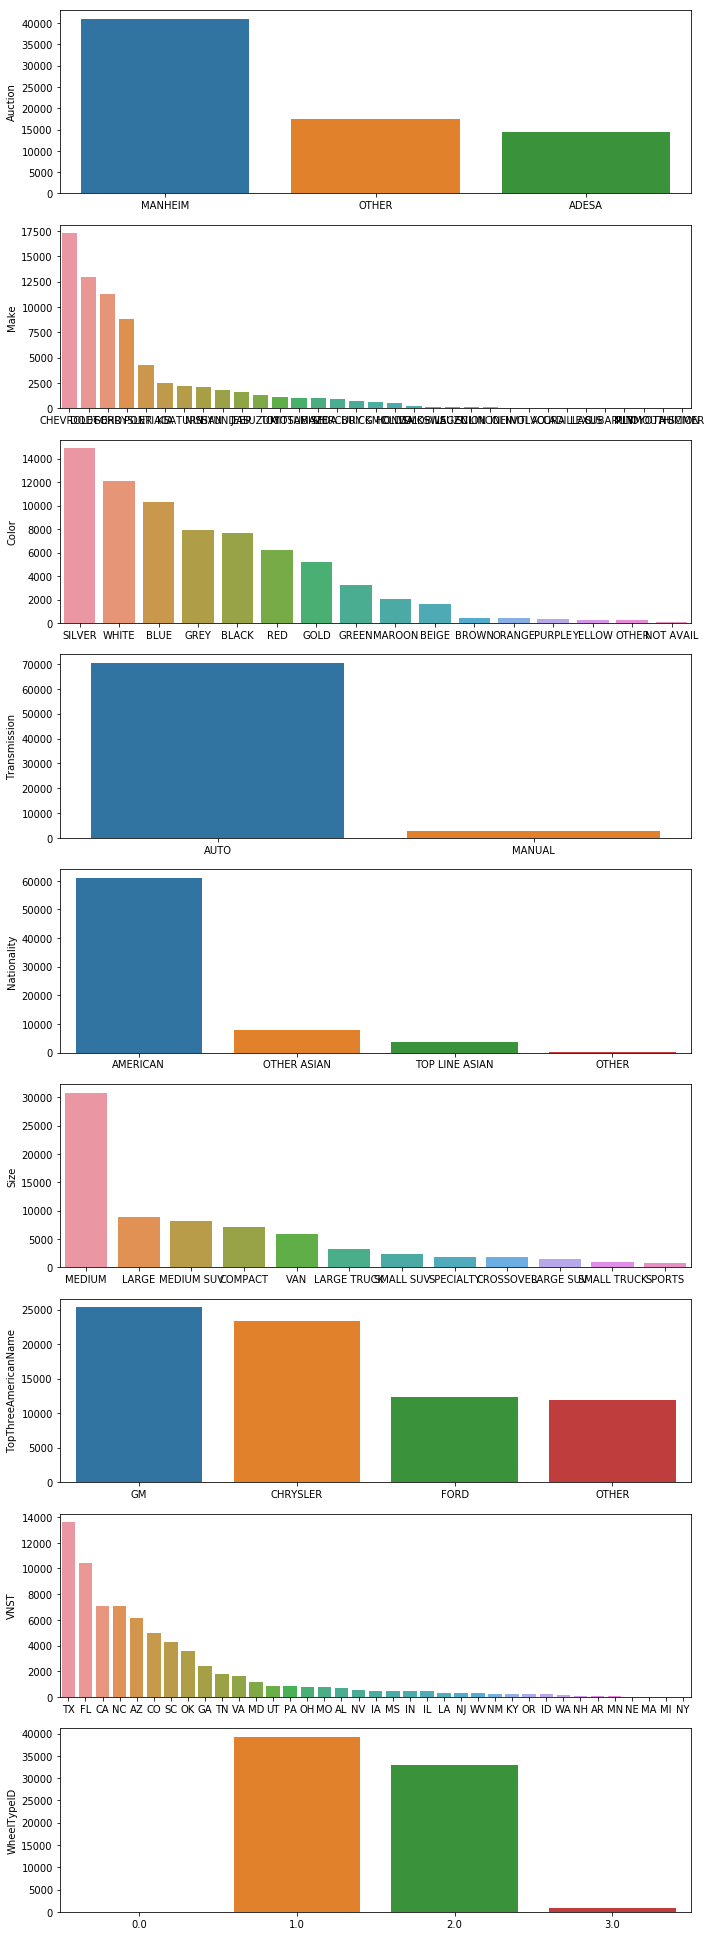

In [49]:
plt.figure(figsize=(10,27))
for i in range(len(categorical_features)):
    plt.subplot(9,1,i+1)
#     sns.set_palette("husl")
    cmap=sns.color_palette("coolwarm", 9)
    count=train_data[categorical_features[i]].value_counts()
    
#    cmap=sns.color_palette("hls", 100)
#     sns.distplot(train_data[categorical_features[i]])
    sns.barplot(count.index,count)
#     plt.title(categorical_features[i])
    
plt.tight_layout()
plt.show()

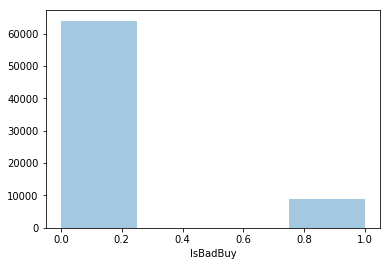

In [50]:
sns.distplot(train_data["IsBadBuy"], kde=False,bins=4)
plt.show()

______________

In [ ]:
def read_data(dire):
    with open (dire,'r',encoding="cp949") as f:
        data=pd.read_csv(f,header=0)
        
    return data

train_data=train_data.drop(["VehYear"],axis=1)
train_data=train_data.drop(["RefId"],axis=1)
train_data=train_data.drop(["Model"],axis=1)
train_data=train_data.drop(["Trim"],axis=1)
train_data=train_data.drop(["SubModel"],axis=1)
train_data=train_data.drop(["WheelType"],axis=1)
train_data=train_data.drop(["PRIMEUNIT"],axis=1)
train_data=train_data.drop(["AUCGUART"],axis=1)
train_data=train_data.drop(["VNZIP1"],axis=1)
train_data=train_data.drop(["PurchDate"],axis=1)
train_data=train_data.drop(["BYRNO"],axis=1)

numerical_features=train_data.select_dtypes(include=["float64", "int64"]).columns.values
numerical_features=np.delete(numerical_features,2)
categorical_features=train_data.select_dtypes(include=["object"]).columns.values
categorical_features=np.append(categorical_features,["WheelTypeID"])

def fill_missing_values(df):
    for col in categorical_features:
        mode=df[col].mode()[0]
        df[col]=df[col].fillna(mode)
    
    for col in numerical_features:
        df[col]=df[col].fillna(df[col].median())   
    
    return df

def data_merge_price_avg(df):
    auction_avg=['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
    df["avg_price"]=sum(df[ave] for ave in auction_avg)/len(auction_avg)
    df=df.drop(auction_avg,axis=1)
    
    return df

train_data=fill_missing_values(train_data)
train_data=data_merge_price_avg(train_data)
train_data.loc[train_data['Transmission']=="Manual","Transmission"]="MANUAL"
transf_contin_value=["VehicleAge","VehOdo","VehBCost","WarrantyCost","avg_price"]


plt.figure(figsize=(10,10))
for i in range(len(transf_contin_value)):
    plt.subplot(5,1,i+1)
#     try:
    sns.distplot(train_data[transf_contin_value[i]])
        
#     except:
    plt.title(transf_contin_value[i])
#         continue
plt.tight_layout()
plt.show()







plt.figure(figsize=(10,10))
for i in range(len(transf_contin_value)):
    plt.subplot(5,1,i+1)
#     try:
    sns.distplot(train_data[transf_contin_value[i]])
        
#     except:
    plt.title(transf_contin_value[i])
#         continue
plt.tight_layout()
plt.show()

-------------------

In [9]:
# 카테고리와 연속 변수 분류
index=[0,12]
numerical_features=np.delete(numerical_features,index)
categorical_features=np.append(categorical_features,["IsBadBuy"])
categorical_features=np.append(categorical_features,["IsOnlineSale"])

# 연속형 변수 상관관계 파악

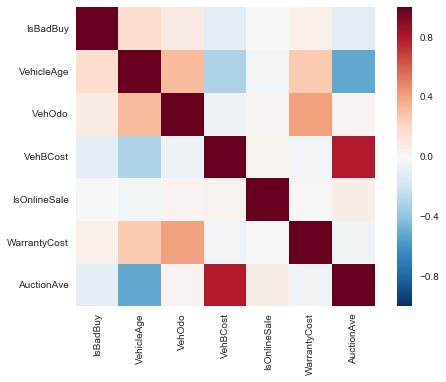

In [13]:
x_cor=train_x.corr()
sns.heatmap(x_cor,square=True)
plt.show()

In [14]:
train_x.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Color', 'Transmission',
       'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName',
       'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'AuctionAve'],
      dtype='object')

In [15]:
category_col=["Auction","Make","Color","Transmission","WheelType","Nationality","Size","TopThreeAmericanName","VNST","IsOnlineSale"]

In [16]:
category_col

['Auction',
 'Make',
 'Color',
 'Transmission',
 'WheelType',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'VNST',
 'IsOnlineSale']